In [2]:
import sys
import os

# Determine the current working directory (assuming you are running this in an interactive environment)
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the system path
sys.path.append(parent_dir)

from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from matplotlib.colors import LinearSegmentedColormap

def normalize_vectors(V):
    """Normalize the columns of V to have a norm of 1."""
    norms = np.linalg.norm(V, axis=0)
    norms[norms == 0] = 1  # Prevent division by zero
    V_normalized = V / norms
    return .02 * V_normalized - .01

def load_h5_file(file_path, dataset_name):
    """Load a dataset from an HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        data = f[dataset_name][:]
    return data

def get_best_correlated_vector(V, eigenvector):
    """Find the row in V (or its negative) that best correlates with the given eigenvector."""
    eigenvector = eigenvector.values.flatten()
    best_corr = -np.inf  # Initialize with a very low correlation
    best_index = -1
    #best_vector = None
    best_vector = np.zeros_like(V[0, :])  # Initialize with a default vector of zeros

    for i in range(V.shape[0]):  # Iterate over all rows in V
        for vec in [V[i, :], -V[i, :]]:  # Check both the row and its negative
            vec = vec.astype(np.float64)  # Ensure vec is a floating-point array
            eigenvector = eigenvector.astype(np.float64)  # Ensure eigenvector is floating-point
            
            # Check if the vector is constant
            if np.all(vec == vec[0]) or np.all(eigenvector == eigenvector[0]):
                continue  # Skip constant vectors
            
            # Synchronize non-NaN data
            valid_indices = ~np.isnan(vec) & ~np.isnan(eigenvector)
            
            if np.any(valid_indices):
                corr, _ = pearsonr(vec[valid_indices], eigenvector[valid_indices])
                if corr > best_corr:  # Check if this is the best correlation so far
                    best_corr = corr
                    best_index = i
                    best_vector = vec

    return best_vector, best_index, best_corr

chromosome = 'chr10'
prefix = 'sc11.ACTTGA'

base_tensor_dir = os.path.join('../../../projects/single_cell_files', 'tensor_1Mb_AB_factors')

input_file = os.path.join(base_tensor_dir, chromosome, f'{prefix}_compartments.h5')
tensor_factors = load_h5_file(input_file, '/compartment_factors')
normalized_tensor_factors = normalize_vectors(tensor_factors)
print(f"Loaded tensor factors from {input_file}, shape: {tensor_factors.shape}")

Loaded tensor factors from ../../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc11.ACTTGA_compartments.h5, shape: (2, 135)


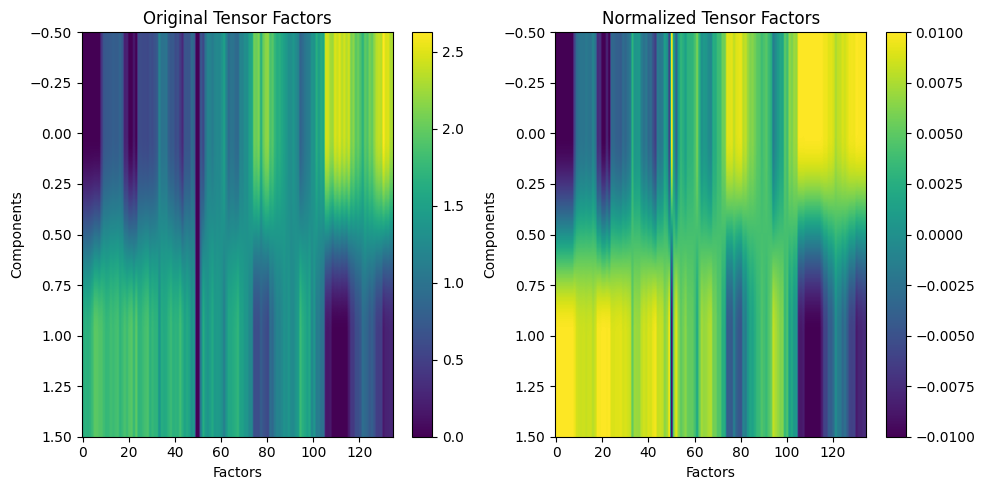

In [3]:
# Plotting the original tensor factors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tensor_factors, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Original Tensor Factors')
plt.xlabel('Factors')
plt.ylabel('Components')

# Plotting the normalized tensor factors
plt.subplot(1, 2, 2)
plt.imshow(normalized_tensor_factors, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Normalized Tensor Factors')
plt.xlabel('Factors')
plt.ylabel('Components')

plt.tight_layout()
plt.show()